In [90]:
from IPython.display import Image, display

In [131]:
from typing import List,  Annotated, TypedDict, operator, Literal
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langchain_tavily import TavilySearch

from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph

## LLM 
llm = init_chat_model(
    model="openai:o3-mini"
)

## Tools 
tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

@tool
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Research scope for this section of the report.",
    )
    content: str = Field(
        description="The content of the section."
    )

@tool
class Sections(BaseModel):
    sections: List[str] = Field(
        description="Sections of the report.",
    )

@tool
class Introduction(BaseModel):
    name: str = Field(
        description="Name for the report.",
    )
    content: str = Field(
        description="The content of the introduction, giving an overview of the report."
    )

@tool
class Conclusion(BaseModel):
    name: str = Field(
        description="Name for the conclusion of the report.",
    )
    content: str = Field(
        description="The content of the conclusion, summarizing the report."
    )

@tool
class Done(BaseModel):
      """Tool to signal that the work is complete."""
      done: bool

## State
class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(MessagesState):
    sections: list[str] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    final_report: str # Final report

class SectionState(MessagesState):
    section: str # Report section  
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

## Supervisor
SUPERVISOR_INSTRUCTIONS = """
You are scoping research for a report based on a user-provided topic.

### Your responsibilities:

1. **Gather Background Information**  
   Based upon the user's topic, use the `tavily_search_tool` to collect relevant information about the topic. 
   - You MUST perform at least  1 search to gather comprehensive context
   - Take time to analyze and synthesize the search results before proceeding
   - Do not proceed to the next step until you have an understanding of the topic

2. **Clarify the Topic**  
   After your initial research, engage with the user to clarify any questions that arose.
   - Ask specific follow-up questions based on what you learned from your searches
   - Do not proceed until you fully understand the topic, goals, constraints, and any preferences
   - Synthesize what you've learned so far before asking questions
   - You MUST engage in at least one clarification exchange with the user before proceeding

3. **Define Report Structure**  
   Only after completing both research AND clarification with the user:
   - Use the `Sections` tool to define a list of report sections
   - Each section should be a written description with: a section name and a section research plan
   - Do not include sections for introductions or conclusions (We'll add these later)
   - Ensure sections are scoped to be independently researchable
   - Base your sections on both the search results AND user clarifications

4. **Assemble the Final Report**  
   When all sections are returned:
   - Use the `Introduction` tool to generate a clear and informative introduction
   - Use the `Conclusion` tool to summarize key insights and close the report

5. **Finish the Workflow**  
   When the final report is complete, call the `Done` tool to signal that the work is finished.

### Additional Notes:
- You are a reasoning model. Think through problems step-by-step before acting.
- IMPORTANT: Do not rush to create the report structure. Gather information thoroughly first.
- Use multiple searches to build a complete picture before drawing conclusions.
- Maintain a clear, informative, and professional tone throughout."""

RESEARCH_INSTRUCTIONS = """
You are a researcher responsible for completing a specific section of a report.

### Your goals:

1. **Understand the Section Scope**  
   Begin by reviewing the section name and description. This defines your research focus. Use it as your objective.


<Section Description>
{section_description}
</Section Description>

2. **Research the Topic**  
   Use the `tavily_search_tool` to gather relevant information and evidence. Search iteratively if needed to fully understand the section's scope.
   - Save the URLs from your searches - you will need to cite them later
   - Aim to gather information from at least 3 different sources

3. **Use the Section Tool**  
   Once you've gathered sufficient context, write a high-quality section using the Section tool:
   - `name`: The title of the section (formatted as a Markdown H2 with ##)
   - `description`: The scope of research you completed (brief, 1-2 sentences)
   - `content`: The completed body of text for the section, which MUST:
     - Be formatted in Markdown style
     - Be MAXIMUM 200 words (strictly enforce this limit)
     - Include a "## Sources" subsection at the end with a numbered list of URLs used
     - Use clear, concise language with bullet points where appropriate
     - Include relevant facts, statistics, or expert opinions

Example format for content:
```
## [Section Title]

[Body text in markdown format, maximum 200 words...]

## Sources
1. [URL 1]
2. [URL 2]
3. [URL 3]
```

---

### Reasoning Guidance

You are a reasoning model. Think through the task step-by-step before writing. Break down complex questions. If you're unsure about something, search again.

- You may reason internally before producing content.
- Your job is not to summarize randomly—it's to **research and synthesize a strong, scoped contribution** to a report.
- Always track and cite your sources.
- Be concise - stay within the 200 word limit for the main content.

---

### Notes:
- Do not write introductions or conclusions unless explicitly part of your section.
- Keep a professional, factual tone.
- If you do not have enough information to complete the section, search again or clarify your approach before continuing.
- Always follow markdown formatting.
"""

# Tools
supervisor_tool_list = [tavily_search_tool, Sections, Introduction, Conclusion, Done]
supervisor_tools_by_name = {tool.name: tool for tool in supervisor_tool_list}

research_tool_list = [tavily_search_tool, Section]
research_tools_by_name = {tool.name: tool for tool in research_tool_list}

def supervisor(state: ReportState):
    """LLM decides whether to call a tool or not"""

    # Messages
    messages = state["messages"]

    # If sections have been defined, then the supervisor has sent them to the research agents, research agents have completed their work, and the supervisor has received the sections
    if state.get("sections"):
        research_complete_message = {"role": "user", "content": "Research is complete. Write the introduction and conclusion. Here is the body of the report to use as context: \n\n" + "\n\n".join([s.content for s in state["sections"]])}
        messages = messages + [research_complete_message]

    # Invoke
    return {
        "messages": [
            llm.bind_tools(supervisor_tool_list).invoke(
                [
                    {"role": "system",
                     "content": SUPERVISOR_INSTRUCTIONS,
                    }
                ]
                + messages
            )
        ]
    }

def supervisor_tools(state: ReportState)  -> Command[Literal["supervisor", "research_team", "__end__"]]:
    """Performs the tool call and sends to the research agent"""

    result = []
    # Get the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = supervisor_tools_by_name[tool_call["name"]]
        # Perform the tool call
        observation = tool.invoke(tool_call["args"])

        # Append to messages 
        result.append({"role": "tool", 
                        "content": observation, 
                        "name": tool_call["name"], 
                        "tool_call_id": tool_call["id"]})
        
        # Update state depending on the tool call 
        if tool_call["name"] == "Sections":
            # Send the sections to the research agents
            # TODO: Discuss w/ Vadym. This is basically a handoff where state is initialized w/ section (scope of research).
            return Command(goto=[Send("research_team", {"section": s}) for s in observation.sections], update={"messages": result})
        
        if tool_call["name"] == "Introduction":
            # Add the introduction to the sections
            return Command(goto="supervisor", update={"sections": [observation] + state["completed_sections"], "messages": result})
        
        if tool_call["name"] == "Conclusion":
            # Compile the final report
            all_sections = "\n\n".join([s.content for s in state["completed_sections"] + [observation]])
            return Command(goto="supervisor", update={"final_report": all_sections, "messages": result})
    
        else:
            return Command(goto="supervisor", update={"messages": result})

def supervisor_should_continue(state: ReportState) -> Literal["supervisor_tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "supervisor_tools"
    
    # Else end because the supervisor asked a question or is finished
    else:
        return END

def research_agent(state: SectionState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Enforce tool calling to either perform more search or call the Section tool to write the section
            llm.bind_tools(research_tool_list).invoke(
                [
                    {"role": "system",
                     "content": RESEARCH_INSTRUCTIONS.format(section_description=state["section"])
                    }
                ]
                + state["messages"]
            )
        ]
    }

def research_agent_tools(state: SectionState):
    """Performs the tool call and route to supervisor or continue the research loop"""

    result = []
    # Get the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = research_tools_by_name[tool_call["name"]]
        # Perform the tool call 
        observation = tool.invoke(tool_call["args"])
        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        # It it wrote the section, send it to the supervisor
        if tool_call["name"] == "Section":
            # Write the competed section to state 
            return {"messages": result, "completed_sections": [observation]}
        # Otherwise continue the research loop            
        else:
            return {"messages": result}

def research_agent_should_continue(state: SectionState) -> Literal["research_agent_tools", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "research_agent_tools"

    else:
        return END
    
# Research agent workflow
research_builder = StateGraph(SectionState, output=SectionOutputState)
research_builder.add_node("research_agent", research_agent)
research_builder.add_node("research_agent_tools", research_agent_tools)
research_builder.add_edge(START, "research_agent") 
research_builder.add_conditional_edges(
    "research_agent",
    research_agent_should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "research_agent_tools": "research_agent_tools",
        END: END,
    },
)
research_builder.add_edge("research_agent_tools", "research_agent")

# Build workflow
supervisor_builder = StateGraph(ReportState, input=MessagesState, output=ReportStateOutput)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_node("research_team", research_builder.compile())

# Flow of the supervisor agent
supervisor_builder.add_edge(START, "supervisor")
supervisor_builder.add_conditional_edges(
    "supervisor",
    supervisor_should_continue ,
    {
        # Name returned by should_continue : Name of next node to visit
        "supervisor_tools": "supervisor_tools",
        END: END,
    },
)
supervisor_builder.add_edge("research_team", "supervisor")
agent = supervisor_builder.compile(name="research_team")

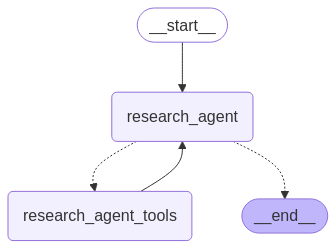

In [132]:
agent = research_builder.compile(name="research_agent")
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

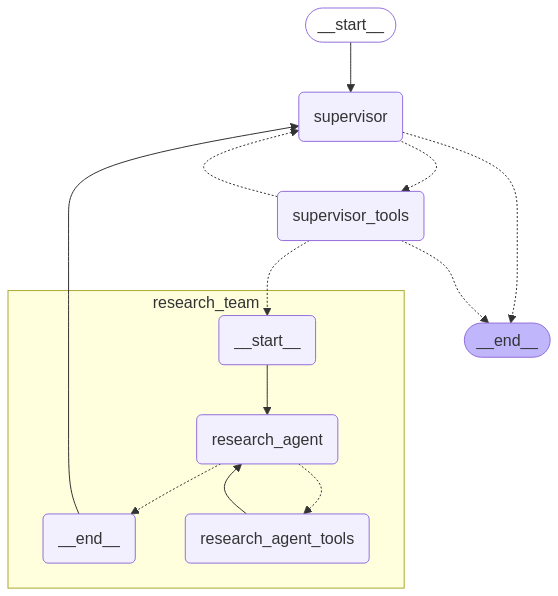

In [133]:
# Compile the supervisor agent
agent = supervisor_builder.compile(name="research_team")
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

In [134]:
import uuid 
from langgraph.checkpoint.memory import MemorySaver

# Checkpointer
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="research_team", checkpointer=checkpointer)

# Run the agent
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}
msg =  [{"role": "user", "content": "What is model context protocol?"}]
# TODO: Why is response empty? Issue w/ invoke?
response = agent.invoke({"messages": msg}, config=thread_config)
for m in agent.get_state(thread_config).values['messages']:
    m.pretty_print()

================================ Human Message =================================

What is model context protocol?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_3EZspWPSg3bXFzlRyoYDf2Sm)
 Call ID: call_3EZspWPSg3bXFzlRyoYDf2Sm
  Args:
    query: What is model context protocol?
================================= Tool Message =================================
Name: tavily_search

{'query': 'What is model context protocol?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'What is Model Context Protocol (MCP) Explained - Beebom', 'url': 'https://beebom.com/model-context-protocol-mcp-explained/', 'content': 'Model Context Protocol (MCP) is an open-source and universal communication protocol that allows AI models to connect to external data sources. Model Context Protocol (MCP) is an open-source standard developed by Anthropic, the company behind the Claude AI chatbot. For instance, you can u

In [135]:
msg =  [{"role": "user", "content": "high-level overview of MCP, tell me about interesting specific MCP servers, developer audience, just focus on MCP."}]
response = agent.invoke({"messages": msg}, config=thread_config)
for m in agent.get_state(thread_config).values['messages']:
    m.pretty_print()

================================ Human Message =================================

What is model context protocol?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_3EZspWPSg3bXFzlRyoYDf2Sm)
 Call ID: call_3EZspWPSg3bXFzlRyoYDf2Sm
  Args:
    query: What is model context protocol?
================================= Tool Message =================================
Name: tavily_search

{'query': 'What is model context protocol?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'What is Model Context Protocol (MCP) Explained - Beebom', 'url': 'https://beebom.com/model-context-protocol-mcp-explained/', 'content': 'Model Context Protocol (MCP) is an open-source and universal communication protocol that allows AI models to connect to external data sources. Model Context Protocol (MCP) is an open-source standard developed by Anthropic, the company behind the Claude AI chatbot. For instance, you can u

/Users/rlm/Desktop/Code/open_deep_research/open-deep-research-env/lib/python3.11/site-packages/langgraph/checkpoint/serde/jsonplus.py:504: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return cls(**tup[2])


In [137]:
from IPython.display import Markdown
Markdown(agent.get_state(thread_config).values['final_report'])

## High-Level Overview of MCP

The Model Context Protocol (MCP) is a universal, open-source standard designed to bridge AI models with external data sources and tools. Key aspects include:

- **Purpose & Rationale:** MCP enables streamlined communication, allowing AI systems to retrieve and process contextual data efficiently, similar to plugging in a device.
- **Origins:** Initially developed to overcome integration barriers and vendor lock-in, MCP promotes modularity and scalability through a client-server architecture.
- **Modular Integration:** Its open-source nature facilitates the creation of lightweight, customizable MCP servers that offer specific capabilities, enhancing context-awareness in AI systems.
- **Practical Benefits:** Developers can seamlessly connect disparate systems, improve data exchange, and incorporate advanced functionalities, exemplified by integrations in platforms like Azure OpenAI.

MCP’s design is shaping the future of AI interactions by providing a standardized, efficient framework for context and tool integration, thereby boosting the flexibility and performance of modern AI applications.

## Sources
1. https://www.keywordsai.co/blog/introduction-to-mcp
2. https://techcommunity.microsoft.com/blog/azure-ai-services-blog/model-context-protocol-mcp-integrating-azure-openai-for-enhanced-tool-integratio/4393788
3. https://stytch.com/blog/model-context-protocol-introduction/

MCP is built on a robust client-server architecture designed for scalable and flexible AI applications. Key architectural elements include:

- **Client-Server Model:** The host application acts as an MCP client, managing connections to multiple MCP servers that provide external tools, resources, and prompt templates.
- **Context Maintenance:** A state-aware protocol retains context across multiple API calls, enabling accurate execution of complex workflows. This is achieved with JSON-RPC based lightweight communication, ensuring efficient message exchange.
- **Security and Scalability:** Integrated authentication and access control create secure communication channels while the modular design allows independent development and deployment of components.
- **Communication Workflow:** 
  - *Initialization*: Exchange of protocol details between clients and servers.
  - *Discovery*: Clients retrieve available tools and data resources.
  - *Context Provision*: Relevant resources are surfaced to support AI operations.

This architecture decouples direct API interactions, allowing AI models to focus on higher-level decision-making while leveraging external servers seamlessly.

## Sources
1. https://zencoder.ai/blog/model-context-protocol
2. https://stytch.com/blog/model-context-protocol-introduction/
3. https://medium.com/@amanatulla1606/anthropics-model-context-protocol-mcp-a-deep-dive-for-developers-1d3db39c9fdc

## Interesting MCP Servers and Implementations

MCP servers bridge AI models with external data sources through a standardized protocol. Noteworthy examples include:

- **Community Servers:** Implementations like OceanBase, Snowflake, TMDB, and Typesense show how diverse data sources can be securely integrated. These serve as benchmarks for building custom connectors tailored to specific use cases.
- **Descope & Zencoder Integrations:** Descope highlights standardized approaches where MCP servers expose functions (e.g., OAuth tokens) that manage secure interactions, while Zencoder emphasizes modular connectors empowering AI-driven functionalities such as chatbots and automation flows.
- **Case Studies:** Early adopters such as Figma and various industry examples in Medium posts illustrate the practical impact of MCP-first development, enabling contextual state management and dynamic tool integrations.

These examples not only emphasize scalability and security but also serve as templates for building robust, context-aware AI applications. Developers can leverage these implementations to streamline integration efforts, reduce development overhead, and innovate in deploying AI across various domains.

## Sources
1. https://medium.com/@vrknetha/the-mcp-first-revolution-why-your-next-application-should-start-with-a-model-context-protocol-9b3d1e973e42
2. https://www.descope.com/learn/post/mcp
3. https://docs.zencoder.ai/features/integrations-and-mcp

Developers can seamlessly integrate MCP by leveraging robust MCP server implementations and adapters like Superinterface and LangChain MCP adapters. Key best practices include:

- **Modular Integration:** Build applications with a clear separation between MCP server and client components using containerized environments (e.g., Docker) for isolated testing.
- **Adapter Utilization:** Use MCP adapters for LangChain and LangGraph to convert MCP tools into compatible modules, reducing setup complexity and accelerating deployment.
- **Robust Testing & Debugging:** Implement comprehensive logging, simulate client-server interactions, and utilize automation tools to verify connections and API responses.
- **Documentation Alignment:** Reference official MCP documentation and community guides to adhere to evolving standards and protocols.
- **Security Considerations:** Secure API keys and ensure network configurations are optimized for responsive interactions between servers and clients.

By following these practices, developers can build resilient AI-powered applications that take full advantage of the MCP ecosystem without manual overhead.

## Sources
1. https://www.trickle.so/blog/10-best-mcp-servers-for-developers
2. https://changelog.langchain.com/announcements/mcp-adapters-for-langchain-and-langgraph
3. https://medium.com/@vrknetha/the-mcp-first-revolution-why-your-next-application-should-start-with-a-model-context-protocol-9b3d1e973e42

The Model Context Protocol (MCP) is an open-source standard designed to bridge AI models and external data sources or tools. MCP enables AI systems to fetch data, execute tasks, and maintain operational context through a standardized communication framework. Key aspects include:

- A flexible, client-server architecture that supports protocols such as JSON-RPC 2.0.
- A design that simplifies integration with various data tools and APIs, enhancing the adaptability and reach of AI models.
- Origins rooted in the need for uniform procedures to handle diverse integrations, as seen in efforts by community leaders and large tech companies.

The rationale behind MCP is to facilitate smoother interactions between AI systems and external resources, leading to improved operational context and robust task execution. It emerges as a solution to the challenge of connecting independent AI components, making integrations more efficient and scalable. MCP’s open-source nature encourages community collaboration and adoption across different platforms, further accelerating innovation in AI integrations.

## Sources
1. https://techcommunity.microsoft.com/blog/azure-ai-services-blog/model-context-protocol-mcp-integrating-azure-openai-for-enhanced-tool-integratio/4393788
2. https://techcommunity.microsoft.com/blog/educatordeveloperblog/unleashing-the-power-of-model-context-protocol-mcp-a-game-changer-in-ai-integrat/4397564
3. https://medium.com/@vincentlambert0/mcp-model-context-protocol-the-open-source-protocol-revolutionizing-ai-integration-25a7a0c2db21

MCP is built on a robust client-server architecture that enables seamless communication between AI models and external APIs. Key architectural features include:

- **Client-Server Interaction:** Clients initiate connections by sending initialization requests, declaring their capabilities. Servers respond with supported features, ensuring both ends understand the available functions.
- **Capability-Based Negotiation:** Both clients and servers exchange capability information during session setup, which unlocks specific protocol features as needed. This negotiation guarantees efficient, context-aware communication.
- **Middleware Functionality:** Operating as a middleware layer, MCP bridges internal model computations with external data sources. It uses standard protocols such as JSON-RPC for message exchange, facilitating consistent and scalable interactions.
- **Error Handling and Transport Protocols:** MCP incorporates error detection and robust handling mechanisms, utilizing HTTP POST for client-to-server messages and Server-Sent Events for server-to-client responses. 

These components combine to extend beyond built-in model knowledge, allowing AI systems to access dynamic, real-time data from various external services.

## Sources
1. https://modelcontextprotocol.io/docs/concepts/architecture
2. https://modelcontextprotocol.io/specification/2025-03-26/architecture
3. https://spec.modelcontextprotocol.io/specification/2025-03-26/architecture/

## Interesting MCP Servers and Implementations

Recent implementations of the Model Context Protocol (MCP) showcase versatile integrations tailored to diverse developer needs. Notable examples include:

- **Descope MCP Server**: Focuses on secure integration with audit logs and user management systems. It standardizes access to external data sources, streamlining identity verification and operational monitoring.

- **Zencoder MCP Integration**: Operates as an MCP client that connects to multiple servers, enabling context-aware workflows. Its modular design supports a variety of tool integrations, ideal for AI assistants and automation flows.

- **Community-driven MCP Servers**: Available on platforms like GitHub, these projects demonstrate flexibility, with examples such as DeepSeek and TMDB servers. They extend MCP’s core capabilities by adding unique functionalities tailored to specific use cases, from database interactions to movie data retrieval.

Each implementation emphasizes lightweight connectivity, ease of integration, and scalability, enabling developers to rapidly deploy applications with advanced context management.

## Sources
1. https://docs.zencoder.ai/features/integrations-and-mcp
2. https://www.descope.com/learn/post/mcp
3. https://github.com/modelcontextprotocol/servers

MCP integration enables seamless communication between AI models and external tools. Developers are advised to follow these best practices:

- **Setup & Configuration**: 
  - Deploy MCP servers with clearly defined tool descriptions and APIs.
  - Integrate MCP clients to bridge your application with these servers.

- **Security**:
  - Implement authentication (e.g., API keys, tokens) to restrict access.
  - Regularly update dependencies to mitigate vulnerabilities.

- **Debugging & Monitoring**:
  - Use logging frameworks to trace requests and diagnose integration issues.
  - Employ sandbox environments for testing new integrations.

- **Context Management**:
  - Ensure robust handling of contextual data to improve model responses.
  - Use dynamic discovery protocols to keep track of available tools.

Practical examples—from case studies and guides by industry experts—demonstrate how these principles lead to efficient, scalable, and secure integrations. Developers can adapt these strategies to streamline operations and capitalize on MCP's modular architecture.

## Sources
1. https://www.keywordsai.co/blog/introduction-to-mcp
2. https://www.blott.studio/blog/post/mcp-explained-building-better-ai-model-interactions
3. https://dysnix.com/blog/model-context-protocol

In conclusion, the Model Context Protocol (MCP) represents a significant leap forward in how AI models interact with external data sources and tools. Its universal, open‐source standard, built on a robust client–server architecture, not only simplifies the integration process but also ensures that AI systems remain both context-aware and scalable. Whether through secure, modular connectors such as Descope and Zencoder implementations or community-driven projects, MCP is paving the way for more dynamic and efficient AI applications. By offering clear guidelines for both integration and best practices, MCP empowers developers to create resilient, adaptable, and innovative AI solutions that can readily communicate with diverse external environments.